In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [207]:
! pip install japanize_matplotlib
! pip install xfeat
! pip install category-encoders

     |████████████████████████████████| 80 kB 4.9 MB/s 


In [208]:
## import module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
from matplotlib_venn import venn2
import os
from statistics import mode

import missingno as msno

from IPython.display import Image

from sklearn.model_selection import KFold, StratifiedKFold
import category_encoders as ce
from xfeat import (SelectCategorical, LabelEncoder, Pipeline, ConcatCombination, SelectNumerical, 
                   ArithmeticCombinations, TargetEncoder, aggregation, GBDTFeatureSelector, GBDTFeatureExplorer)
from sklearn import preprocessing
from time import time
from contextlib import contextmanager
import lightgbm as lgb

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [143]:
class CFG:
  exp = "exp05"
  seed = 71
  fold = 4

CONFIG = CFG()

In [5]:
input_dir = "/content/drive/MyDrive/KMI_ddbrothers/hirahara/data/"
output_dir = "/content/drive/MyDrive/KMI_ddbrothers/hirahara/output/"

# データフレームの形状変換

In [260]:
pd.set_option("display.max_colwidth", 300)

# Import file
df1 = pd.read_csv(input_dir + "gi_train_mm10.csv")
df2 = pd.read_csv(input_dir + "gi_train_mm11.csv")
df_test = pd.read_csv(input_dir + "gi_test.csv")
sample_submit = pd.read_csv(input_dir + "gi_sample_submit.csv")
df_train = pd.concat([df1,df2]).reset_index(drop=True)

df_train = df_train[~df_train.customer_id.isnull()].reset_index()

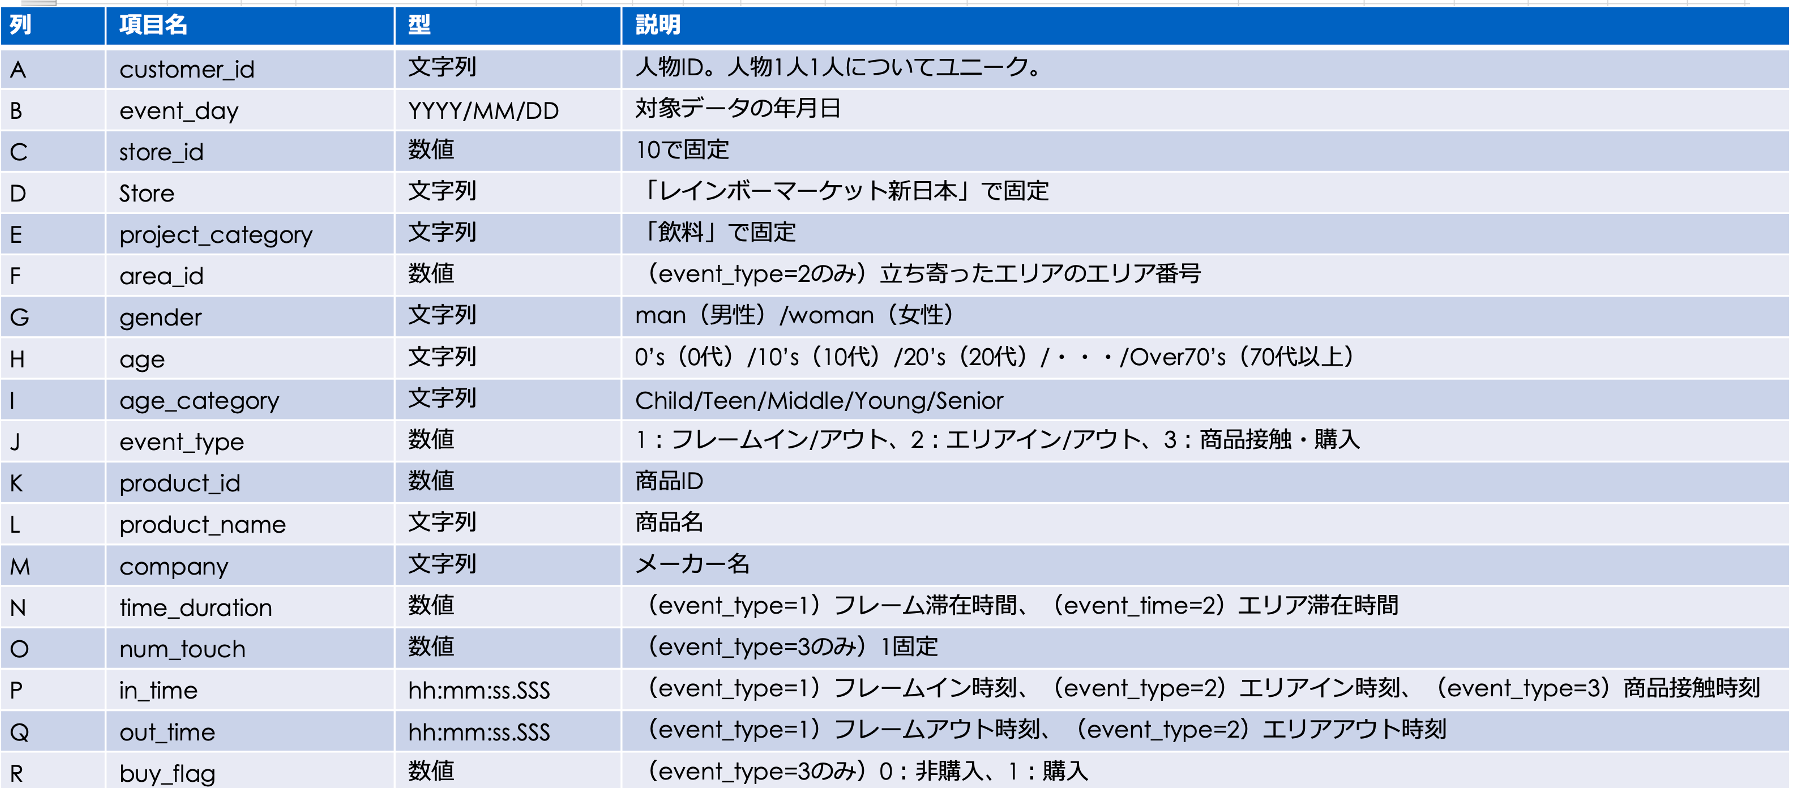

In [225]:
Image(input_dir + "description.png", width = 1000)

In [226]:
df_train.describe()

,index,store_id,area_id,event_type,product_id,time_duration,num_touch,buy_flag
count,20277.000000,20277.0,6480.000000,20277.000000,7002.000000,20277.000000,7002.0,7002.000000
mean,10151.354194,10.0,2.637500,2.010209,50.059840,18.180658,1.0,0.741074
std,5868.043787,0.0,1.439391,0.824837,38.881656,28.341374,0.0,0.438076
min,0.000000,10.0,1.000000,1.000000,1.000000,0.000000,1.0,0.000000
25%,5069.000000,10.0,1.000000,1.000000,17.000000,0.000000,1.0,0.000000
50%,10138.000000,10.0,3.000000,2.000000,41.000000,9.200000,1.0,1.000000
75%,15240.000000,10.0,4.000000,3.000000,83.000000,23.600000,1.0,1.000000
max,20316.000000,10.0,5.000000,3.000000,136.000000,421.600000,1.0,1.000000


In [227]:
sample_submit.shape

(4530, 2)

In [228]:
df_train

,index,customer_id,event_day,store_id,store,project_category,area_id,gender,age,age_category,event_type,product_id,product_name,company,time_duration,num_touch,in_time,out_time,buy_flag
0,0,20201026-010001,2020/10/26,10,レインボーマーケット新日本,飲料,NaN,woman,30's,Young,1,NaN,NaN,NaN,6.2,NaN,08:01:50.200,08:01:56.400,NaN
1,1,20201026-010002,2020/10/26,10,レインボーマーケット新日本,飲料,NaN,man,50's,Middle,1,NaN,NaN,NaN,13.6,NaN,08:02:43.600,08:02:57.200,NaN
2,2,20201026-010003,2020/10/26,10,レインボーマーケット新日本,飲料,NaN,man,50's,Middle,1,NaN,NaN,NaN,14.2,NaN,08:02:57.800,08:03:12.000,NaN
3,3,20201026-010004,2020/10/26,10,レインボーマーケット新日本,飲料,NaN,man,10's,Teen,1,NaN,NaN,NaN,21.0,NaN,08:06:13.200,08:06:34.200,NaN
4,4,20201026-010005,2020/10/26,10,レインボーマーケット新日本,飲料,NaN,woman,30's,Young,1,NaN,NaN,NaN,19.2,NaN,08:07:06.000,08:07:25.200,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20272,20312,20201101-120054,2020/11/1,10,レインボーマーケット新日本,飲料,NaN,man,30's,Young,3,94.0,うるうるグリーンティー525ml,エターナル,0.0,1.0,21:38:20.200,NaN,0.0
20273,20313,20201101-120054,2020/11/1,10,レインボーマーケット新日本,飲料,NaN,man,30's,Young,3,27.0,新緑の丘525ml,フューチャー,0.0,1.0,21:38:20.800,NaN,0.0
20274,20314,20201101-120054,2020/11/1,10,レインボーマーケット新日本,飲料,NaN,man,30's,Young,3,27.0,新緑の丘525ml,フューチャー,0.0,1.0,21:38:21.200,NaN,1.0
20275,20315,20201101-120055,2020/11/1,10,レインボーマーケット新日本,飲料,NaN,woman,30's,Young,3,4.0,ジャパンスプラッシュ500ml,クオリティー,0.0,1.0,21:39:33.800,NaN,0.0


In [229]:
df_train = df_train[['customer_id',
                     'event_day', 
                     #'store_id', 
                     #'store',
                     #'project_category',
                     'area_id',
                     'gender', 
                     'age', 
                     'age_category',
                     'event_type',
                     'product_id', 
                     'product_name', 
                     'company', 
                     'time_duration',
                     'num_touch', 
                     'in_time',
                     'out_time', 
                     'buy_flag']]

df_test = df_test[['customer_id',
                     'event_day', 
                     #'store_id', 
                     #'store',
                     #'project_category',
                     'area_id',
                     'gender', 
                     'age', 
                     'age_category',
                     'event_type',
                     'product_id', 
                     'product_name', 
                     'company', 
                     'time_duration',
                     'num_touch',
                     'in_time',
                     'out_time']]

## データフレームへの時間特徴量の追加

In [230]:
df_train =df_train.copy()
df_test =df_test.copy()

df_train["in_time"]=pd.to_datetime(df_train["in_time"])
df_train["out_time"]=pd.to_datetime(df_train["out_time"])
df_test["in_time"]=pd.to_datetime(df_test["in_time"])
df_test["out_time"]=pd.to_datetime(df_test["out_time"])

In [231]:
#Eventtype=1のin_timeとEventtype=3のin_time
def event1in_time_event3in_time_duration(df,customer_id,datetime):

    df_base3=df[df['customer_id']==customer_id]
    event1=df_base3[df_base3['event_type']==1]
    
    event3_in_time=datetime
    event1_in_time=event1['in_time']
    time_duration=event3_in_time-event1_in_time
    time_duration=time_duration.item().seconds

    return time_duration

In [232]:
#Eventtype=3のin_timeとEventtype=1のout_time差
def event3in_time_event1out_time_duration(df,customer_id,datetime):

    df_base3=df[df['customer_id']==customer_id]
    event1_out_time=df_base3[df_base3['event_type']==1]['out_time']
    
    event3_in_time=datetime
    time_duration=event1_out_time-event3_in_time
    time_duration=time_duration.item().seconds

    return time_duration

In [234]:
df_train['1in_3in']=df_train.apply(lambda x: event1in_time_event3in_time_duration(df_train,x['customer_id'],x['in_time']), axis=1)
df_train['3in_1out']=df_train.apply(lambda x: event3in_time_event1out_time_duration(df_train,x['customer_id'],x['in_time']), axis=1)

df_test['1in_3in']=df_test.apply(lambda x: event1in_time_event3in_time_duration(df_test,x['customer_id'],x['in_time']), axis=1)
df_test['3in_1out']=df_test.apply(lambda x: event3in_time_event1out_time_duration(df_test,x['customer_id'],x['in_time']), axis=1)

In [235]:
df_train[df_train.customer_id=="20201101-120054"]

,customer_id,event_day,area_id,gender,age,age_category,event_type,product_id,product_name,company,time_duration,num_touch,in_time,out_time,buy_flag,1in_3in,3in_1out
17691,20201101-120054,2020/11/1,NaN,man,30's,Young,1,NaN,NaN,NaN,28.4,NaN,2021-09-19 21:38:07.200,2021-09-19 21:38:35.600,NaN,0,28
18904,20201101-120054,2020/11/1,1.0,man,30's,Young,2,NaN,NaN,NaN,11.2,NaN,2021-09-19 21:38:15.600,2021-09-19 21:38:26.800,NaN,8,20
20272,20201101-120054,2020/11/1,NaN,man,30's,Young,3,94.0,うるうるグリーンティー525ml,エターナル,0.0,1.0,2021-09-19 21:38:20.200,NaT,0.0,13,15
20273,20201101-120054,2020/11/1,NaN,man,30's,Young,3,27.0,新緑の丘525ml,フューチャー,0.0,1.0,2021-09-19 21:38:20.800,NaT,0.0,13,14
20274,20201101-120054,2020/11/1,NaN,man,30's,Young,3,27.0,新緑の丘525ml,フューチャー,0.0,1.0,2021-09-19 21:38:21.200,NaT,1.0,14,14


In [237]:
df_train.to_pickle(input_dir + "train_rev.pkl")
df_test.to_pickle(input_dir + "test_rev.pkl")

# 処理済みデータ読み込み

In [296]:
df_train = pd.read_pickle(input_dir + "train_rev.pkl")
df_test = pd.read_pickle(input_dir + "test_rev.pkl")

In [308]:
df_train[df_train.customer_id=="20201026-010002"]

,customer_id,event_day,area_id,gender,age,age_category,event_type,product_id,product_name,company,time_duration,num_touch,in_time,out_time,buy_flag,1in_3in,3in_1out
1,20201026-010002,2020/10/26,NaN,man,50's,Middle,1,NaN,NaN,NaN,13.6,NaN,2021-09-19 08:02:43.600,2021-09-19 08:02:57.200,NaN,0,13
5492,20201026-010002,2020/10/26,1.0,man,50's,Middle,2,NaN,NaN,NaN,7.8,NaN,2021-09-19 08:02:49.400,2021-09-19 08:02:57.200,NaN,5,7
10760,20201026-010002,2020/10/26,NaN,man,50's,Middle,3,6.0,クリアブラウン525ml,クオリティー,0.0,1.0,2021-09-19 08:02:50.400,NaT,1.0,6,6
10761,20201026-010002,2020/10/26,NaN,man,50's,Middle,3,1.0,トラディショナル緑茶525ml,クオリティー,0.0,1.0,2021-09-19 08:02:54.200,NaT,1.0,10,3


In [309]:
df_train[df_train.num_touch>=1]

,customer_id,event_day,area_id,gender,age,age_category,event_type,product_id,product_name,company,time_duration,num_touch,in_time,out_time,buy_flag,1in_3in,3in_1out
10758,20201026-010001,2020/10/26,NaN,woman,30's,Young,3,1.0,トラディショナル緑茶525ml,クオリティー,0.0,1.0,2021-09-19 08:01:51.400,NaT,1.0,1,5
10759,20201026-010001,2020/10/26,NaN,woman,30's,Young,3,1.0,トラディショナル緑茶525ml,クオリティー,0.0,1.0,2021-09-19 08:01:53.600,NaT,1.0,3,2
10760,20201026-010002,2020/10/26,NaN,man,50's,Middle,3,6.0,クリアブラウン525ml,クオリティー,0.0,1.0,2021-09-19 08:02:50.400,NaT,1.0,6,6
10761,20201026-010002,2020/10/26,NaN,man,50's,Middle,3,1.0,トラディショナル緑茶525ml,クオリティー,0.0,1.0,2021-09-19 08:02:54.200,NaT,1.0,10,3
10762,20201026-010003,2020/10/26,NaN,man,50's,Middle,3,42.0,桃の世界410ml,フューチャー,0.0,1.0,2021-09-19 08:03:00.400,NaT,1.0,2,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20272,20201101-120054,2020/11/1,NaN,man,30's,Young,3,94.0,うるうるグリーンティー525ml,エターナル,0.0,1.0,2021-09-19 21:38:20.200,NaT,0.0,13,15
20273,20201101-120054,2020/11/1,NaN,man,30's,Young,3,27.0,新緑の丘525ml,フューチャー,0.0,1.0,2021-09-19 21:38:20.800,NaT,0.0,13,14
20274,20201101-120054,2020/11/1,NaN,man,30's,Young,3,27.0,新緑の丘525ml,フューチャー,0.0,1.0,2021-09-19 21:38:21.200,NaT,1.0,14,14
20275,20201101-120055,2020/11/1,NaN,woman,30's,Young,3,4.0,ジャパンスプラッシュ500ml,クオリティー,0.0,1.0,2021-09-19 21:39:33.800,NaT,0.0,6,7


In [298]:
df_train1 = df_train[df_train.event_type ==1].reset_index(drop=True)
df_train2 = df_train[df_train.event_type ==2].reset_index(drop=True)
df_train3 = df_train[df_train.event_type ==3].reset_index(drop=True)

df_test1 = df_test[df_test.event_type ==1].reset_index(drop=True)
df_test2 = df_test[df_test.event_type ==2].reset_index(drop=True)
df_test3 = df_test[df_test.event_type ==3].reset_index(drop=True)

In [299]:
df_train3

,customer_id,event_day,area_id,gender,age,age_category,event_type,product_id,product_name,company,time_duration,num_touch,in_time,out_time,buy_flag,1in_3in,3in_1out
0,20201026-010001,2020/10/26,NaN,woman,30's,Young,3,1.0,トラディショナル緑茶525ml,クオリティー,0.0,1.0,2021-09-19 08:01:51.400,NaT,1.0,1,5
1,20201026-010001,2020/10/26,NaN,woman,30's,Young,3,1.0,トラディショナル緑茶525ml,クオリティー,0.0,1.0,2021-09-19 08:01:53.600,NaT,1.0,3,2
2,20201026-010002,2020/10/26,NaN,man,50's,Middle,3,6.0,クリアブラウン525ml,クオリティー,0.0,1.0,2021-09-19 08:02:50.400,NaT,1.0,6,6
3,20201026-010002,2020/10/26,NaN,man,50's,Middle,3,1.0,トラディショナル緑茶525ml,クオリティー,0.0,1.0,2021-09-19 08:02:54.200,NaT,1.0,10,3
4,20201026-010003,2020/10/26,NaN,man,50's,Middle,3,42.0,桃の世界410ml,フューチャー,0.0,1.0,2021-09-19 08:03:00.400,NaT,1.0,2,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6997,20201101-120054,2020/11/1,NaN,man,30's,Young,3,94.0,うるうるグリーンティー525ml,エターナル,0.0,1.0,2021-09-19 21:38:20.200,NaT,0.0,13,15
6998,20201101-120054,2020/11/1,NaN,man,30's,Young,3,27.0,新緑の丘525ml,フューチャー,0.0,1.0,2021-09-19 21:38:20.800,NaT,0.0,13,14
6999,20201101-120054,2020/11/1,NaN,man,30's,Young,3,27.0,新緑の丘525ml,フューチャー,0.0,1.0,2021-09-19 21:38:21.200,NaT,1.0,14,14
7000,20201101-120055,2020/11/1,NaN,woman,30's,Young,3,4.0,ジャパンスプラッシュ500ml,クオリティー,0.0,1.0,2021-09-19 21:39:33.800,NaT,0.0,6,7


In [305]:
company_df = pd.concat([df_train3,df_test3],axis=0)[["product_name","company"]].drop_duplicates().reset_index(drop=True)

df_item_train_1=  df_train3[["customer_id","product_name","buy_flag"]]
df_item_train_1 = df_item_train_1[df_item_train_1.buy_flag >=1].reset_index(drop=True) 
df_item_train_1 = df_item_train_1.drop_duplicates(subset="customer_id",keep="last").reset_index(drop=True)
df_item_train_1 = pd.merge(df_item_train_1,company_df,on="product_name")

df_item_train_0=  df_train3[["customer_id","product_name","buy_flag"]]
df_item_train_0 = df_item_train_0[df_item_train_0.buy_flag ==0].reset_index(drop=True) 
df_item_train_0 = df_item_train_0.drop_duplicates(subset="customer_id",keep="last").reset_index(drop=True)
df_item_train_0 = pd.merge(df_item_train_0,company_df,on="product_name")

In [306]:
df_item_train = pd.concat([df_item_train_1,df_item_train_0],axis=0).sort_values("customer_id").set_index("customer_id").drop(columns="buy_flag")

In [307]:
df_item_train

,product_name,company
customer_id,,
20201026-010001,トラディショナル緑茶525ml,クオリティー
20201026-010002,トラディショナル緑茶525ml,クオリティー
20201026-010003,桃の世界410ml,フューチャー
20201026-010005,アフタヌーンレモンティー500ml,エターナル
20201026-010007,ワイルドオレ500ml,ラボラトリー
...,...,...
20201101-120053,トルマリン600ml,フューチャー
20201101-120054,新緑の丘525ml,フューチャー
20201101-120054,新緑の丘525ml,フューチャー


## Customer_IDごとの各特徴量の整理

In [265]:
#shopper属性
df_shopper_train=df_train[["customer_id","gender","age","age_category","event_day"]].drop_duplicates().set_index("customer_id")
df_shopper_test=df_test[["customer_id","gender","age","age_category","event_day"]].drop_duplicates().set_index("customer_id")

#shopper接触回数（合計）
df_contact_train = df_train.groupby("customer_id")[["num_touch"]].sum().astype(int)
df_contact_test = df_test.groupby("customer_id")[["num_touch"]].sum().astype(int)

#shopper area id
df_area_train=pd.crosstab(df_train2.customer_id,df_train2.area_id).fillna(0).astype(int)
df_area_train.columns=["area_1","area_2","area_3","area_4","area_5"]
df_area_test=pd.crosstab(df_test2.customer_id,df_test2.area_id).fillna(0).astype(int)
df_area_test.columns=["area_1","area_2","area_3","area_4","area_5"]

#shpper area time
df_areatime_train=pd.pivot_table(df_train2,index="customer_id",columns="area_id",values="time_duration").fillna(0)
df_areatime_train.columns=["area_time_1","area_time_2","area_time_3","area_time_4","area_time_5"]
df_areatime_test=pd.pivot_table(df_test2,index="customer_id",columns="area_id",values="time_duration").fillna(0)
df_areatime_test.columns=["area_time_1","area_time_2","area_time_3","area_time_4","area_time_5"]

#shopper frame time
df_frametime_train=df_train1[["customer_id","time_duration","in_time","out_time"]].drop_duplicates().set_index("customer_id")
df_frametime_test=df_test1[["customer_id","time_duration","in_time","out_time"]].drop_duplicates().set_index("customer_id")

#shopper_touch_items
#df_touch_item_train=df_train[df_train.num_touch > 0][["customer_id","product_name","product_id","company"]]
#df_touch_item_train=pd.crosstab(df_touch_item_train.customer_id,df_touch_item_train.product_name).astype(int)
#df_touch_item_test=df_test[df_test.num_touch > 0][["customer_id","product_name","product_id","company"]]
#df_touch_item_test=pd.crosstab(df_touch_item_test.customer_id,df_touch_item_test.product_name).astype(int)

#shopper_touch_items_company
#df_touch_item_comp_train=df_train[df_train.num_touch > 0][["customer_id","product_name","product_id","company"]]
#df_touch_item_comp_train=pd.crosstab(df_touch_item_comp_train.customer_id,df_touch_item_comp_train.company).astype(int)
#df_touch_item_comp_test=df_test[df_test.num_touch > 0][["customer_id","product_name","product_id","company"]]
#df_touch_item_comp_test=pd.crosstab(df_touch_item_comp_test.customer_id,df_touch_item_comp_test.company).astype(int)

#3in1/1in3 time
df_time_ba_train = df_train3.sort_values("customer_id").drop_duplicates(subset="customer_id",keep="last").reset_index(drop=True)
df_time_ba_train = df_time_ba_train[["customer_id","1in_3in","3in_1out"]].set_index("customer_id")

df_time_ba_test = df_test3.sort_values("customer_id").drop_duplicates(subset="customer_id",keep="last").reset_index(drop=True)
df_time_ba_test = df_time_ba_test[["customer_id","1in_3in","3in_1out"]].set_index("customer_id")

#last touch item
company_df = pd.concat([df_train3,df_test3],axis=0)[["product_name","company"]].drop_duplicates().reset_index(drop=True)

df_item_train_1=  df_train3[["customer_id","product_name","buy_flag"]]
df_item_train_1 = df_item_train_1[df_item_train_1.buy_flag >=1].reset_index(drop=True) 
df_item_train_1 = df_item_train_1.drop_duplicates(subset="customer_id",keep="last").reset_index(drop=True)
df_item_train_1 = pd.merge(df_item_train_1,company_df,on="product_name")

df_item_train_0=  df_train3[["customer_id","product_name","buy_flag"]]
df_item_train_0 = df_item_train_0[df_item_train_0.buy_flag ==0].reset_index(drop=True) 
df_item_train_0 = df_item_train_0.drop_duplicates(subset="customer_id",keep="last").reset_index(drop=True)
df_item_train_0 = pd.merge(df_item_train_0,company_df,on="product_name")

df_item_train = pd.concat([df_item_train_1,df_item_train_0],axis=0).sort_values("customer_id").set_index("customer_id").drop(columns="buy_flag")

df_item_test=df_test3[["customer_id","product_name"]].reset_index(drop=True)
df_item_test = df_item_test.drop_duplicates(subset="customer_id",keep="last").reset_index(drop=True)
df_item_test = pd.merge(df_item_test,company_df,on="product_name").set_index("customer_id")

#shopper購入回数(合計）
df_buy_train = df_train.groupby("customer_id")[["buy_flag"]].sum().astype(int)


In [266]:
df_train = pd.concat([df_shopper_train, 
                      df_contact_train,
                      df_area_train,
                      df_areatime_train,
                      df_frametime_train,
                      #df_item_train,
                      df_time_ba_train,
                      df_touch_item_train,
                      df_buy_train],
                      axis=1)

#接触していない顧客は除く
df_train = df_train.fillna(0).reset_index()
df_train = df_train[df_train.num_touch!=0].reset_index(drop=True)
df_train=df_train.drop(columns=["out_time"])

df_test = pd.concat([df_shopper_test, 
                      df_contact_test,
                      df_area_test,
                      df_areatime_test,
                      df_frametime_test,
                      df_time_ba_test,
                      df_touch_item_test],
                      #df_item_test],
                      axis=1)

df_test = df_test.fillna(0).reset_index()

#接触してない顧客は強制的に0
df_test_0 =df_test[df_test.num_touch==0].reset_index(drop=True)
df_test=df_test[df_test.num_touch!=0].reset_index(drop=True)
df_test=df_test.drop(columns=["out_time"])

In [267]:
df_train[df_train["index"]=="20201101-120054"]

,index,gender,age,age_category,event_day,num_touch,area_1,area_2,area_3,area_4,area_5,area_time_1,area_time_2,area_time_3,area_time_4,area_time_5,time_duration,in_time,1in_3in,3in_1out,3時のオレ500ml,Cウォーター500ml,あなたのソーダ500ml,あの日のソーダ500ml,うつくし檸檬水500ml,うるうるグリーンティー525ml,おいしい新茶470ml,おいしい時間555ml,おそば屋さんのお茶500ml,かろやかアップル425ml,かろやかオレンジ425ml,きよらかなリンゴ水430ml,こだわりコーヒー無糖500ml,こゆいオレ500ml,ごくごくスポドリ500ml,しゅわしゅわオレンジ420ml,しゅわしゅわプルーン500ml,しゅわしゅわミックスベリー500ml,しゅわしゅわ檸檬ライム470ml,しゅわっとれもん450ml,...,健康志向500ml,優しい君500ml,匠の果実500ml,単純なぶどう水430ml,古のサイダー500ml,天然水100の炭酸水500ml,天然水100の炭酸水レモン500ml,岩清水555ml,強烈スマッシュ500ml,愛の告白500ml,摘みたて茶葉430ml,新緑の丘525ml,日本の伝統525ml,朝の雫540ml,本当のオレンジ490ml,柑橘フレッシュ410ml,桃の世界410ml,森の光600ml,楊貴妃500ml,水玉ウォーター500ml,河のせせらぎ500ml,激熱苺480ml,無農薬健康茶600ml,燃えろイナヅマ600ml,燕ブランドのローストグリーンティー525ml,爆発GP480ml,玄米のおいしいお茶500ml,玉露水525ml,職人の力500ml,花の癒し500ml,花束を君に500ml,贅沢の極み500ml,贅沢乳酸菌ドリンク500ml,酸っぱい果実555ml,雪のしずく550ml,電撃蜜柑410ml,飛び出した檸檬水500ml,麦の息吹660ml,黒の息吹500ml,buy_flag
3315,20201101-120054,man,30's,Young,2020/11/1,3,1.0,0.0,0.0,0.0,0.0,11.2,0.0,0.0,0.0,0.0,28.4,2021-09-19 21:38:07.200,14.0,14.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [269]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3317 entries, 0 to 3316
Columns: 157 entries, index to buy_flag
dtypes: datetime64[ns](1), float64(149), int64(2), object(5)
memory usage: 4.0+ MB


In [270]:
df_test

,index,gender,age,age_category,event_day,num_touch,area_1,area_2,area_3,area_4,area_5,area_time_1,area_time_2,area_time_3,area_time_4,area_time_5,time_duration,in_time,1in_3in,3in_1out,3時のオレ500ml,Cウォーター500ml,あなたのソーダ500ml,あの日のソーダ500ml,うつくし檸檬水500ml,うるうるグリーンティー525ml,おいしい新茶470ml,おいしい時間555ml,おそば屋さんのお茶500ml,かろやかアップル425ml,かろやかオレンジ425ml,きよらかなリンゴ水430ml,こだわりコーヒー無糖500ml,こゆいオレ500ml,ごくごくスポドリ500ml,しゅわしゅわオレンジ420ml,しゅわしゅわプルーン500ml,しゅわしゅわミックスベリー500ml,しゅわしゅわ檸檬ライム470ml,しゅわっとれもん450ml,...,健康の国500ml,健康志向500ml,優しい君500ml,匠の果実500ml,単純なぶどう水430ml,古のサイダー500ml,天然水100の炭酸水500ml,天然水100の炭酸水レモン500ml,岩清水555ml,強烈スマッシュ500ml,愛の告白500ml,摘みたて茶葉430ml,新緑の丘525ml,日本の伝統525ml,朝の雫540ml,本当のオレンジ490ml,柑橘フレッシュ410ml,桃の世界410ml,森の光600ml,楊貴妃500ml,水玉ウォーター500ml,河のせせらぎ500ml,激熱苺480ml,無農薬健康茶600ml,燃えろイナヅマ600ml,燕ブランドのローストグリーンティー525ml,爆発GP480ml,玄米のおいしいお茶500ml,玉露水525ml,職人の力500ml,花の癒し500ml,花束を君に500ml,贅沢の極み500ml,贅沢乳酸菌ドリンク500ml,酸っぱい果実555ml,雪のしずく550ml,電撃蜜柑410ml,飛び出した檸檬水500ml,麦の息吹660ml,黒の息吹500ml
0,20201026-010006,man,40's,Middle,2020/10/26,2,1.0,0.0,0.0,0.0,0.0,7.2,0.0,0.0,0.0,0.0,19.8,2021-09-19 08:07:13.000,10.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20201026-010008,man,40's,Middle,2020/10/26,3,1.0,1.0,0.0,0.0,0.0,4.8,5.2,0.0,0.0,0.0,21.2,2021-09-19 08:10:32.600,12.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20201026-010011,man,50's,Middle,2020/10/26,1,0.0,1.0,0.0,0.0,0.0,0.0,8.2,0.0,0.0,0.0,19.4,2021-09-19 08:11:34.400,11.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,20201026-010012,woman,20's,Young,2020/10/26,1,1.0,0.0,0.0,0.0,0.0,3.8,0.0,0.0,0.0,0.0,15.2,2021-09-19 08:12:40.600,7.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,20201026-010018,man,10's,Teen,2020/10/26,1,1.0,0.0,0.0,0.0,0.0,11.2,0.0,0.0,0.0,0.0,23.0,2021-09-19 08:19:33.000,9.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2199,20201101-120031,woman,50's,Middle,2020/11/1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5.8,14.4,2021-09-19 21:07:27.000,10.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2200,20201101-120033,man,30's,Young,2020/11/1,2,2.0,2.0,1.0,0.0,0.0,20.2,10.2,17.2,0.0,0.0,86.2,2021-09-19 21:07:49.000,78.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2201,20201101-120051,woman,40's,Middle,2020/11/1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.2,2021-09-19 21:36:05.200,17.0,6.0,0.0,0.0,0.0,

# 前処理

## buy flagの変換(購入しなかった:0 / 購入した:1)

In [271]:
def flag_change(x):
    if x == 0:
        x=0
        return x
    else:
        x=1
        return x

df_train["buy_flag"] = df_train["buy_flag"].apply(lambda x : flag_change(x))

In [272]:
df_train.buy_flag.unique()

array([1, 0])

In [273]:
df_train.buy_flag.value_counts()

1    3021
0     296
Name: buy_flag, dtype: int64

## 容量のカラム追加

In [187]:
size_train=df_train.product_name.str.extract(r'(\d\d\d)').astype(int)
df_train.insert(loc = 19, column= 'size', value= size_train)

size_test=df_test.product_name.str.extract(r'(\d\d\d)').astype(int)
df_test.insert(loc = 19, column= 'size', value= size_test)

In [188]:
df_train

,index,gender,age,age_category,event_day,num_touch,area_1,area_2,area_3,area_4,area_5,area_time_1,area_time_2,area_time_3,area_time_4,area_time_5,time_duration,in_time,product_name,size,company,1in_3in,3in_1out,buy_flag
0,20201026-010001,woman,30's,Young,2020/10/26,2,1.0,0.0,0.0,0.0,0.0,6.2,0.0,0.0,0.0,0.0,6.2,2021-09-19 08:01:50.200,トラディショナル緑茶525ml,525,クオリティー,3.0,2.0,1
1,20201026-010002,man,50's,Middle,2020/10/26,2,1.0,0.0,0.0,0.0,0.0,7.8,0.0,0.0,0.0,0.0,13.6,2021-09-19 08:02:43.600,トラディショナル緑茶525ml,525,クオリティー,10.0,3.0,1
2,20201026-010003,man,50's,Middle,2020/10/26,3,1.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,14.2,2021-09-19 08:02:57.800,桃の世界410ml,410,フューチャー,6.0,8.0,1
3,20201026-010005,woman,30's,Young,2020/10/26,1,1.0,0.0,0.0,0.0,0.0,4.8,0.0,0.0,0.0,0.0,19.2,2021-09-19 08:07:06.000,アフタヌーンレモンティー500ml,500,エターナル,8.0,11.0,1
4,20201026-010007,man,30's,Young,2020/10/26,1,0.0,1.0,0.0,0.0,0.0,0.0,44.0,0.0,0.0,0.0,78.6,2021-09-19 08:10:19.200,ワイルドオレ500ml,500,ラボラトリー,29.0,49.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3312,20201101-120049,woman,40's,Middle,2020/11/1,1,1.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,11.2,2021-09-19 21:30:25.200,新緑の丘525ml,525,フューチャー,9.0,1.0,1
3313,20201101-120050,man,30's,Young,2020/11/1,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,14.4,16.4,2021-09-19 21:34:24.800,ジャパンスプラッシュ500ml,500,クオリティー,8.0,8.0,1
3314,20201101-120053,man,30's,Young,2020/11/1,11,1.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0,42.2,2021-09-19 21:37:08.400,トルマリン600ml,600,フューチャー,28.0,13.0,1
3315,20201101-120054,man,30's,Young,2020/11/1,3,1.0,0.0,0.0,0.0,0.0,11.2,0.0,0.0,0.0,0.0,28.4,2021-09-19 21:38:07.200,新緑の丘525ml,525,フューチャー,14.0,14.0,1


## 入時間の設定

In [274]:
#エントリータイムの時間を抽出
df_train["in_time"] = pd.to_datetime(df_train["in_time"])
df_train["in_time"] = df_train["in_time"].apply(lambda x: x.hour)
df_train["in_time"] =df_train["in_time"].astype("object")

df_test["in_time"] = pd.to_datetime(df_test["in_time"])
df_test["in_time"] = df_test["in_time"].apply(lambda x: x.hour)
df_test["in_time"] =df_test["in_time"].astype("object")

#曜日
df_train["event_day"] = pd.to_datetime(df_train["event_day"])
df_train["event_day"] = df_train["event_day"].apply(lambda x: x.weekday())
df_train["event_day"] =df_train["event_day"].astype("object")

df_test["event_day"] = pd.to_datetime(df_test["event_day"])
df_test["event_day"] = df_test["event_day"].apply(lambda x: x.weekday())
df_test["event_day"] =df_test["event_day"].astype("object")

In [275]:
df_train

,index,gender,age,age_category,event_day,num_touch,area_1,area_2,area_3,area_4,area_5,area_time_1,area_time_2,area_time_3,area_time_4,area_time_5,time_duration,in_time,1in_3in,3in_1out,3時のオレ500ml,Cウォーター500ml,あなたのソーダ500ml,あの日のソーダ500ml,うつくし檸檬水500ml,うるうるグリーンティー525ml,おいしい新茶470ml,おいしい時間555ml,おそば屋さんのお茶500ml,かろやかアップル425ml,かろやかオレンジ425ml,きよらかなリンゴ水430ml,こだわりコーヒー無糖500ml,こゆいオレ500ml,ごくごくスポドリ500ml,しゅわしゅわオレンジ420ml,しゅわしゅわプルーン500ml,しゅわしゅわミックスベリー500ml,しゅわしゅわ檸檬ライム470ml,しゅわっとれもん450ml,...,健康志向500ml,優しい君500ml,匠の果実500ml,単純なぶどう水430ml,古のサイダー500ml,天然水100の炭酸水500ml,天然水100の炭酸水レモン500ml,岩清水555ml,強烈スマッシュ500ml,愛の告白500ml,摘みたて茶葉430ml,新緑の丘525ml,日本の伝統525ml,朝の雫540ml,本当のオレンジ490ml,柑橘フレッシュ410ml,桃の世界410ml,森の光600ml,楊貴妃500ml,水玉ウォーター500ml,河のせせらぎ500ml,激熱苺480ml,無農薬健康茶600ml,燃えろイナヅマ600ml,燕ブランドのローストグリーンティー525ml,爆発GP480ml,玄米のおいしいお茶500ml,玉露水525ml,職人の力500ml,花の癒し500ml,花束を君に500ml,贅沢の極み500ml,贅沢乳酸菌ドリンク500ml,酸っぱい果実555ml,雪のしずく550ml,電撃蜜柑410ml,飛び出した檸檬水500ml,麦の息吹660ml,黒の息吹500ml,buy_flag
0,20201026-010001,woman,30's,Young,0,2,1.0,0.0,0.0,0.0,0.0,6.2,0.0,0.0,0.0,0.0,6.2,8,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,20201026-010002,man,50's,Middle,0,2,1.0,0.0,0.0,0.0,0.0,7.8,0.0,0.0,0.0,0.0,13.6,8,10.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,20201026-010003,man,50's,Middle,0,3,1.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,14.2,8,6.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,20201026-010005,woman,30's,Young,0,1,1.0,0.0,0.0,0.0,0.0,4.8,0.0,0.0,0.0,0.0,19.2,8,8.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,20201026-010007,man,30's,Young,0,1,0.0,1.0,0.0,0.0,0.0,0.0,44.0,0.0,0.0,0.0,78.6,8,29.0,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3312,20201101-120049,woman,40's,Middle,6,1,1.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,11.2,21,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3313,20201101-120050,man,30's,Young,6,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,14.4,16.4,21,8.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3314,20201101-120053,man,30's,Young,6,11,1.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0,42.2,21,28.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3315,20201101-120054,man,30's

In [276]:
df_train.columns

Index(['index', 'gender', 'age', 'age_category', 'event_day', 'num_touch',
       'area_1', 'area_2', 'area_3', 'area_4',
       ...
       '花束を君に500ml', '贅沢の極み500ml', '贅沢乳酸菌ドリンク500ml', '酸っぱい果実555ml',
       '雪のしずく550ml', '電撃蜜柑410ml', '飛び出した檸檬水500ml', '麦の息吹660ml', '黒の息吹500ml',
       'buy_flag'],
      dtype='object', length=157)

## カテゴリカルエンコーディング

In [278]:
# BaseBlock
class BaseBlock(object):
    def fit(self, input_df, y=None):
        return self.transform(input_df)
    
    def transform(self, input_df):
        raise NotImplementedError()
        
# CountEncoding
class CountEncodingBlock(BaseBlock):
    def __init__(self, cols):
        self.cols = cols
        self.encoder = None
        
    def fit(self, input_df, y=None):
        return self.transform(input_df[self.cols])
    
    def transform(self, input_df):
        self.encoder = ce.CountEncoder()
        self.encoder.fit(input_df[self.cols])
        return self.encoder.transform(input_df[self.cols]).add_prefix("CE_")

# OneHotEncoding
class OneHotEncodingBlock(BaseBlock):
    def __init__(self, cols):
        self.cols = cols
        self.encoder = None
        
    def fit(self, input_df, y=None):
        self.encoder = ce.OneHotEncoder(use_cat_names=True)
        self.encoder.fit(input_df[self.cols])
        return self.transform(input_df[self.cols])
    
    def transform(self, input_df):
        return self.encoder.transform(input_df[self.cols]).add_prefix("OHE_")

# OrdinalEncoding
class OrdinalEncodingBlock(BaseBlock):
    def __init__(self, cols):
        self.cols = cols
        self.encoder = None
        
    def fit(self, input_df, y=None):
        self.encoder = ce.OrdinalEncoder()
        self.encoder.fit(input_df[self.cols])
        return self.transform(input_df[self.cols])
    
    def transform(self, input_df):
        return self.encoder.transform(input_df[self.cols]).add_prefix("OE_")

In [288]:
def get_ce_features(input_df):
    _input_df = pd.concat([input_df], axis=1)
    
    cols = ['gender',
            'age',
            'age_category', 
            'event_day', 
            #'num_touch',
            'in_time'] 
            #'product_name', 
            #'size', 
            #'company']
    encoder = CountEncodingBlock(cols = cols)
    output_df = encoder.fit(_input_df.astype(str))
    return output_df


def get_oe_features(input_df):
    _input_df = pd.concat([input_df], axis=1)
    cols = ['gender',
            'age',
            'age_category', 
            'event_day', 
            #'num_touch',
            'in_time'] 
            #'product_name', 
            #'size', 
            #'company']
    encoder = OrdinalEncodingBlock(cols = cols)
    output_df = encoder.fit(_input_df)
    return output_df

# not use
def get_ohe_features(input_df):
    _input_df = pd.concat([input_df], axis=1)
    cols = ['gender',
            'age',
            'age_category', 
            'event_day', 
            #'num_touch',
            'in_time'] 
            #'product_name', 
            #'size', 
            #'company']
    encoder = OneHotEncodingBlock(cols=cols)
    output_df = encoder.fit(_input_df)
    return output_df

In [289]:
df_train_ce=get_ce_features(df_train)
df_train_oe=get_oe_features(df_train)

In [290]:
target = df_train["buy_flag"]
df_train_encoded = df_train.drop(columns=["index","gender","age","age_category","event_day","in_time","buy_flag"])
df_train_encoded = pd.concat([df_train_encoded,df_train_ce,df_train_oe],axis=1)
df_train_encoded["buy_flag"] = target 

In [291]:
df_train_encoded

,num_touch,area_1,area_2,area_3,area_4,area_5,area_time_1,area_time_2,area_time_3,area_time_4,area_time_5,time_duration,1in_3in,3in_1out,3時のオレ500ml,Cウォーター500ml,あなたのソーダ500ml,あの日のソーダ500ml,うつくし檸檬水500ml,うるうるグリーンティー525ml,おいしい新茶470ml,おいしい時間555ml,おそば屋さんのお茶500ml,かろやかアップル425ml,かろやかオレンジ425ml,きよらかなリンゴ水430ml,こだわりコーヒー無糖500ml,こゆいオレ500ml,ごくごくスポドリ500ml,しゅわしゅわオレンジ420ml,しゅわしゅわプルーン500ml,しゅわしゅわミックスベリー500ml,しゅわしゅわ檸檬ライム470ml,しゅわっとれもん450ml,すっぱいかんきつドリンク400ml,ちょこっとファイバー100ml,つぶつぶミカンジュース400ml,つよーい炭酸水490ml,はじけたグレープ500ml,はじけろオレンジ500ml,...,摘みたて茶葉430ml,新緑の丘525ml,日本の伝統525ml,朝の雫540ml,本当のオレンジ490ml,柑橘フレッシュ410ml,桃の世界410ml,森の光600ml,楊貴妃500ml,水玉ウォーター500ml,河のせせらぎ500ml,激熱苺480ml,無農薬健康茶600ml,燃えろイナヅマ600ml,燕ブランドのローストグリーンティー525ml,爆発GP480ml,玄米のおいしいお茶500ml,玉露水525ml,職人の力500ml,花の癒し500ml,花束を君に500ml,贅沢の極み500ml,贅沢乳酸菌ドリンク500ml,酸っぱい果実555ml,雪のしずく550ml,電撃蜜柑410ml,飛び出した檸檬水500ml,麦の息吹660ml,黒の息吹500ml,CE_gender,CE_age,CE_age_category,CE_event_day,CE_in_time,OE_gender,OE_age,OE_age_category,OE_event_day,OE_in_time,buy_flag
0,2,1.0,0.0,0.0,0.0,0.0,6.2,0.0,0.0,0.0,0.0,6.2,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1717,708,999,453,169,1,1,1,1,1,1
1,2,1.0,0.0,0.0,0.0,0.0,7.8,0.0,0.0,0.0,0.0,13.6,10.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1600,655,1445,453,169,2,2,2,1,1,1
2,3,1.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,14.2,6.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1600,655,1445,453,169,2,2,2,1,1,1
3,1,1.0,0.0,0.0,0.0,0.0,4.8,0.0,0.0,0.0,0.0,19.2,8.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1717,708,999,453,169,1,1,1,1,1,1
4,1,0.0,1.0,0.0,0.0,0.0,0.0,44.0,0.0,0.0,0.0,78.6,29.0,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1600,708,999,453,169,2,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3312,1,1.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,11.2,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1717,790,1445,575,96,1,4,2,7,14,1
3313,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,14.4,16.4,8.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1600,708,999,575,96,2,1,1,7,14,1
3314,11,1.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0,42.2,28.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1600,708,999,575,96,2,1,1,7,14,1
3315,3,1.0,0.0,0.0,0.0,0.0,11.2,0.0,0.0,0.0,0.0,28.4,14.0,14.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

# モデル作成　(Light GBM)

In [292]:
@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

In [293]:
def fit_lgbm(X, y, cv, params: dict=None, verbose: int=100):
    
    metric_func = roc_auc_score
    metrics_func_sub = accuracy_score
    
    if params is None:
        params = {}

    models = []
    borders=[]
    
    # training data の target と同じだけのゼロ配列を用意
    oof_pred_df = pd.DataFrame()

    for i, (idx_train, idx_valid) in enumerate(cv): 
        # 交差検証 データセットを cv instance によって分割
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgb.LGBMClassifier(**params)

        # auc_score用のborder算出(単純にデータ数で閾値を決定）
        border = y_valid.sum() / len(x_valid)
        borders.append(border)

        print(f"Best_Score_Border： {border}")

        with timer(prefix='fit fold={} '.format(i + 1)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=verbose,
                    verbose=verbose)
        
        # border で1, 0を分離するので、確率で算出する

        pred_i = clf.predict_proba(x_valid)[:, 1]

        pred_b = np.where(pred_i < border, 0, 1)
        print(f'AUC {i} Score: {metric_func(y_valid, pred_b) :.4f}')
        print(f'Accuracy {i} Score: {metrics_func_sub(y_valid, pred_b) :.4f}')
        
        oof_fold_df = pd.DataFrame(np.zeros_like(y_valid, dtype=np.float)).rename(columns={0:"pred"})
        oof_fold_df["id"]=idx_valid
        oof_fold_df["fold"]=i+1
        oof_fold_df["pred_prob"] = pred_i
        oof_fold_df["pred_bool"] = pred_b
        
        oof_pred_df=pd.concat([oof_pred_df,oof_fold_df],axis=0)
        
        
        models.append(clf)
        
    oof_pred_df=oof_pred_df.sort_values("id").reset_index(drop=True).set_index("id").reindex(['fold', 'y', 'pred_prob','pred_bool'], axis='columns')
    oof_pred_df["y"]=y
    score = metric_func(y, oof_pred_df["pred_prob"]) 
    print('FINISHED | AUC Score: {:.4f}'.format(score))
    return oof_pred_df, models

## 学習

In [294]:
params = {
    'learning_rate': 0.01,
    'n_estimators': 10000,
    'objective':"binary",
    'class_weight':"balanced",
    'max_depth': 200,
    #"early_stopping_rounds": 100,
    "random_state":71
    }

fold = StratifiedKFold(n_splits=CONFIG.fold, shuffle=True, random_state=CONFIG.seed)
cv = list(fold.split(df_train_encoded, df_train_encoded["buy_flag"]))

train_x = df_train_encoded.iloc[:,:-1]
train_y = df_train_encoded["buy_flag"]


oof, models = fit_lgbm(train_x.values, train_y, cv, params=None)

Best_Score_Border： 0.9108433734939759
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.327971
Did not meet early stopping. Best iteration is:
[12]	valid_0's binary_logloss: 0.279525
fit fold=1 0.224[s]
AUC 0 Score: 0.6483
Accuracy 0 Score: 0.7590
Best_Score_Border： 0.9107358262967431
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.314529
Did not meet early stopping. Best iteration is:
[9]	valid_0's binary_logloss: 0.279389
fit fold=2 0.202[s]
AUC 1 Score: 0.6829
Accuracy 1 Score: 0.7443
Best_Score_Border： 0.9107358262967431
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.352347
Did not meet early stopping. Best iteration is:
[21]	valid_0's binary_logloss: 0.282995
fit fold=3 0.220[s]
AUC 2 Score: 0.6300
Accuracy 2 Score: 0.7479
Best_Score_Border： 0.9107358262967431
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's

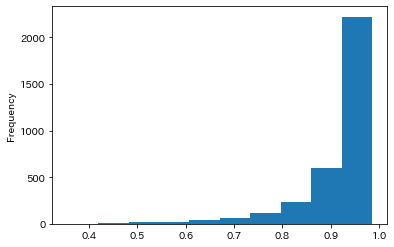

In [146]:
oof["pred_prob"].plot(kind="hist")

## 学習結果

In [147]:
#特徴量の可視化
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現する.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(10, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='Blues_d', 
                  orient='h')
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    
    return fig, ax

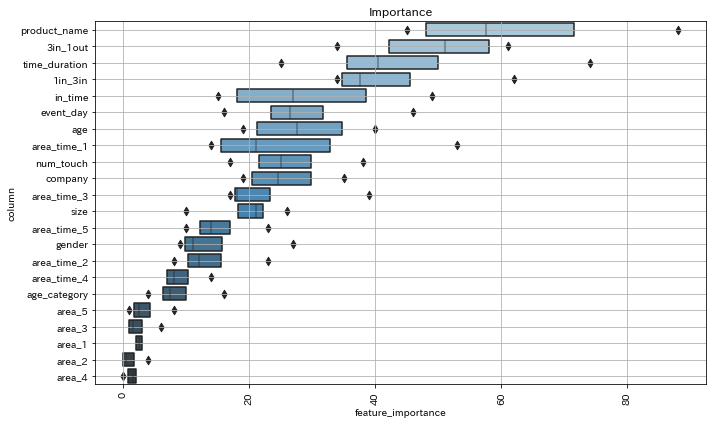

In [148]:
fig, ax = visualize_importance(models, train_x)

In [149]:
#ROCカーブの可視化
def visulalize_roc(df, fold):
    """各foldおよび出力平均のROCカーブを描画する

    args:
        df:出力oof df
        fold: fold数
    """
    
    fig = plt.figure(figsize=[8,8])
    
    tprs = []
    aucs = []
    
    mean_fpr = np.linspace(0,1,100)
    
    i = 1
    
    folds = list(range(1,fold+1))
    

    for v in folds:
        
        df_tmp = df[df.fold==v]
        fpr, tpr, t = roc_curve(df_tmp["y"], df_tmp["pred_prob"])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.3f)' % (i, roc_auc))
        i= i+1

    plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='blue',
             label=r'Mean ROC (AUC = %0.3f )' % (mean_auc),lw=2, alpha=1)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")

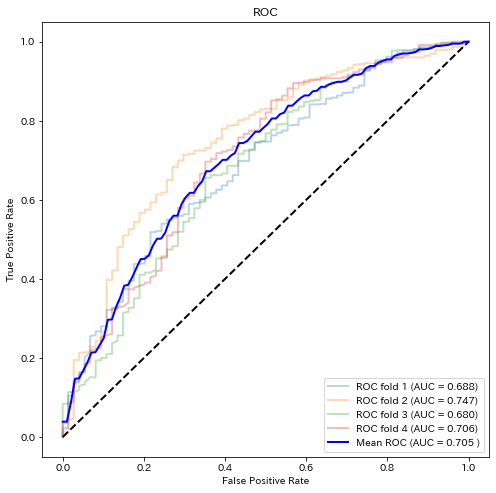

In [150]:
visulalize_roc(oof,CONFIG.fold)

In [151]:
#混合行列の可視化
def visualize_confusion_matrix(y_true,pred_label,height=.6,labels=None):
    
    """
    混合行列をプロットする
    """
    
    conf = confusion_matrix(y_true=y_true,
                            y_pred=pred_label,
                            normalize='true')

    n_labels = len(conf)
    size = n_labels * height
    fig, ax = plt.subplots(figsize=(size * 4, size * 3))
    sns.heatmap(conf, cmap='Blues', ax=ax, annot=True, fmt='.2f')
    ax.set_ylabel('Label')
    ax.set_xlabel('Predict')

    if labels is not None:
        ax.set_yticklabels(labels)
        ax.set_xticklabels(labels)
        ax.tick_params('y', labelrotation=0)
        ax.tick_params('x', labelrotation=90)

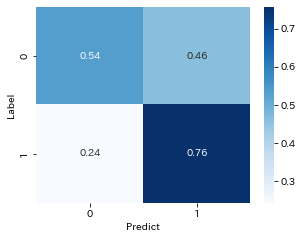

In [152]:
visualize_confusion_matrix(y_true=oof.y,pred_label=oof.pred_bool)

## 予測

In [53]:
df_index = df_test_encoded["index"]
df_test_pred = df_test_encoded.iloc[:,1:]

pred = np.array([model.predict(df_test_pred.values) for model in models])
pred = np.mean(pred, axis=0)

In [54]:
submission_pred = pd.DataFrame()
submission_pred["customer_id"] = df_index
submission_pred["buy_proba"] = pred

In [55]:
submission_pred

,customer_id,buy_proba
0,20201026-010006,1.0
1,20201026-010008,1.0
2,20201026-010011,1.0
3,20201026-010012,1.0
4,20201026-010018,1.0
...,...,...
2199,20201101-120031,1.0
2200,20201101-120033,1.0
2201,20201101-120051,1.0
2202,20201101-120052,1.0


In [56]:
submission_pred_0 = pd.DataFrame()
submission_pred_0["customer_id"] = df_test_0["index"]
submission_pred_0["buy_proba"] = 0

In [57]:
submission_pred_0

,customer_id,buy_proba
0,20201026-010030,0
1,20201026-010034,0
2,20201026-010060,0
3,20201026-010066,0
4,20201026-010082,0
...,...,...
2321,20201101-120014,0
2322,20201101-120029,0
2323,20201101-120035,0
2324,20201101-120039,0


In [58]:
submission_pred_all = pd.concat([submission_pred,submission_pred_0],axis=0).sort_values("customer_id").reset_index(drop=True)

In [59]:
submission_pred_all

,customer_id,buy_proba
0,20201026-010006,1.0
1,20201026-010008,1.0
2,20201026-010011,1.0
3,20201026-010012,1.0
4,20201026-010018,1.0
...,...,...
4525,20201101-120039,0.0
4526,20201101-120046,0.0
4527,20201101-120051,1.0
4528,20201101-120052,1.0


In [60]:
submission_pred_all.to_csv(output_dir + CONFIG.exp+ "_submission.csv",index=False)